In [1]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
sns.set()

import toypipeline

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput'

# Decide on experiment's configuration

layers.0.weight tensor([[2.]], device='cuda:0') 



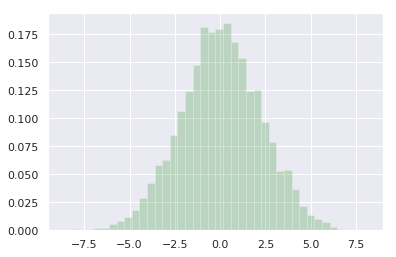

In [2]:
DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 10000
WITH_BIASX = False
WITH_LOGVARX = False

FRAC_VAL = 0.2

W_TRUE = {}
B_TRUE = {}

W_TRUE[0] = [[2.]]

if WITH_LOGVARX:
    assert len(W_TRUE) == N_DECODER_LAYERS + 1, len(W_TRUE)
else:
    assert len(W_TRUE) == N_DECODER_LAYERS

WITH_BIASZ = True
WITH_LOGVARZ = True

config_decoder_true = toynn.make_decoder_true(
    w_true=W_TRUE, b_true=B_TRUE, latent_dim=LATENT_DIM, 
    data_dim=DATA_DIM, n_layers=N_DECODER_LAYERS,
    nonlinearity=NONLINEARITY, with_biasx=WITH_BIASX, with_logvarx=WITH_LOGVARX)

for name, param in config_decoder_true.named_parameters():
    print(name, param.data, '\n')

generated_true_x = toynn.generate_from_decoder(config_decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Safety checks on configuration

In [3]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

assert config_decoder_true.latent_dim == decoder_true.latent_dim
assert config_decoder_true.data_dim == decoder_true.data_dim
assert config_decoder_true.n_layers == decoder_true.n_layers
assert config_decoder_true.nonlinearity == decoder_true.nonlinearity
assert config_decoder_true.with_logvarx == decoder_true.with_logvarx

assert config_decoder_true.layers[0].weight[[0]] == decoder_true.layers[0].weight[[0]]

print('Decoder: Safety CHECKED.')

Decoder: Safety CHECKED.


In [4]:
assert DATA_DIM == toypipeline.DATA_DIM
assert LATENT_DIM == toypipeline.LATENT_DIM
assert N_DECODER_LAYERS == toypipeline.N_DECODER_LAYERS
assert NONLINEARITY == toypipeline.NONLINEARITY
assert N_SAMPLES == toypipeline.N_SAMPLES
assert WITH_BIASX == toypipeline.WITH_BIASX
assert WITH_LOGVARX == toypipeline.WITH_LOGVARX
assert FRAC_VAL == toypipeline.FRAC_VAL
assert W_TRUE == toypipeline.W_TRUE
assert B_TRUE == toypipeline.B_TRUE
assert WITH_BIASZ == toypipeline.WITH_BIASZ
assert WITH_LOGVARZ == toypipeline.WITH_LOGVARZ

print('CONSTANTS: Safety CHECKED.')

CONSTANTS: Safety CHECKED.


In [5]:
dataset_path = glob.glob(f'{OUTPUT}/synthetic/dataset.npy')[0]
dataset = np.load(dataset_path)

assert len(dataset) == N_SAMPLES

print('Dataset: Safety CHECKED.')

Dataset: Safety CHECKED.


# Inspect Functions

In [6]:
N_TRAIN = int((1 - FRAC_VAL) * N_SAMPLES)

def min_neg_loglikelihood(val=False): 
    subdataset = torch.Tensor(dataset[:N_TRAIN,])  
    if val:
        subdataset = torch.Tensor(dataset[N_TRAIN:,])
        
    w_mle_square = torch.mean(subdataset ** 2, dim=0) - 1 
    w_mle = torch.sqrt(w_mle_square)
    w_mle = torch.Tensor(w_mle).to(DEVICE)
    
    min_neg_loglikelihood = toylosses.fa_neg_loglikelihood(w_mle, subdataset)
    
    min_neg_loglikelihood = min_neg_loglikelihood.cpu().numpy()
    w_mle = w_mle.cpu().numpy()
    
    return w_mle, min_neg_loglikelihood  

In [7]:
def print_weights(algo_name='vae'):
    decoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/decoder.pth')[0]
    decoder = torch.load(decoder_path, map_location=DEVICE)
    print('-- True values of parameters')
    for name, param in decoder_true.named_parameters():
        print(name, param.data, '\n')

    print('\n-- Learnt values of parameters')
    for name, param in decoder.named_parameters():
        print(name, param.data, '\n')

In [8]:
def plot_neg_elbo_and_nlls(ax, algo_name='vae', from_epoch=0, trained_on_this=''):
    train_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

    val_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/val_losses.pkl')[0]
    val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

    # Extract loss that is used for backpropagation, i. e. for training
    train_losses_total = [loss['neg_elbo'] for loss in train_losses_all_epochs]
    val_losses_total = [loss['neg_elbo'] for loss in val_losses_all_epochs]
    
    n_epochs = len(train_losses_total)
    epochs = range(n_epochs)

    # Extract true negloglikelihood of the current weights in the decoder
    train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
    val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]
    
    # Get minimum values for the neg loglikelihood given this training and validation sets
    _, train_min_nll = min_neg_loglikelihood()
    train_min_nll = np.repeat(train_min_nll, n_epochs)
    
    _, val_min_nll = min_neg_loglikelihood(val=True)
    val_min_nll = np.repeat(val_min_nll, n_epochs)
 
    ax.plot(epochs[from_epoch:], train_nll[from_epoch:], label='Train NLL')
    ax.plot(epochs[from_epoch:], val_nll[from_epoch:], label='Valid NLL')

    ax.plot(epochs[from_epoch:], train_min_nll[from_epoch:], label='NLL on Training Set MLE')
    ax.plot(epochs[from_epoch:], val_min_nll[from_epoch:], label='NLL on Valid Set MLE')
    
    ax.plot(epochs[from_epoch:], train_losses_total[from_epoch:], label=f'Train ELBO{trained_on_this}')
    ax.plot(epochs[from_epoch:], val_losses_total[from_epoch:], label=f'Valid ELBO{trained_on_this}')
    
    ax.set_title(f'Training and validation losses for {algo_name}.')
    ax.legend()
    return ax

In [9]:
def plot_neg_iwelbo_and_nlls(ax, algo_name='vae', from_epoch=0, trained_on_this=''):
    train_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

    val_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/val_losses.pkl')[0]
    val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

    # Extract loss that is used for backpropagation, i. e. for training
    train_losses_total = [loss['neg_iwelbo'] for loss in train_losses_all_epochs]
    val_losses_total = [loss['neg_iwelbo'] for loss in val_losses_all_epochs]
    
    n_epochs = len(train_losses_total)
    epochs = range(n_epochs)

    # Extract true negloglikelihood of the current weights in the decoder
    train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
    val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]
    
    # Get minimum values for the neg loglikelihood given this training and validation sets
    _, train_min_nll = min_neg_loglikelihood()
    train_min_nll = np.repeat(train_min_nll, n_epochs)
    
    _, val_min_nll = min_neg_loglikelihood(val=True)
    val_min_nll = np.repeat(val_min_nll, n_epochs)
    
    ax.plot(epochs[from_epoch:], train_nll[from_epoch:], label='Train NLL')
    ax.plot(epochs[from_epoch:], val_nll[from_epoch:], label='Valid NLL')

    ax.plot(epochs[from_epoch:], train_min_nll[from_epoch:], label='NLL on Training Set MLE')
    ax.plot(epochs[from_epoch:], val_min_nll[from_epoch:], label='NLL on Valid Set MLE')
    
    ax.plot(epochs[from_epoch:], train_losses_total[from_epoch:], label=f'Train IWAE{trained_on_this}')
    ax.plot(epochs[from_epoch:], val_losses_total[from_epoch:], label=f'Valid IWAE{trained_on_this}')
    
    ax.set_title(f'Training and validation losses for {algo_name}.')
    ax.legend()
    return ax

In [10]:
def plot_nlls(ax, algo_name='vae', from_epoch=0):
    train_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

    val_losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/val_losses.pkl')[0]
    val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

    n_epochs = len(train_losses_all_epochs)
    epochs = range(n_epochs)

    # Extract true negloglikelihood of the current weights in the decoder
    train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
    val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]
    
    # Get minimum values for the neg loglikelihood given this training and validation sets
    _, train_min_nll = min_neg_loglikelihood()
    train_min_nll = np.repeat(train_min_nll, n_epochs)
    
    _, val_min_nll = min_neg_loglikelihood(val=True)
    val_min_nll = np.repeat(val_min_nll, n_epochs)
    
    ax.plot(epochs[from_epoch:], train_nll[from_epoch:], label='Train NLL')
    ax.plot(epochs[from_epoch:], val_nll[from_epoch:], label='Valid NLL')

    ax.plot(epochs[from_epoch:], train_min_nll[from_epoch:], label='NLL on Training Set MLE')
    ax.plot(epochs[from_epoch:], val_min_nll[from_epoch:], label='NLL on Valid Set MLE')
    
    ax.set_title(f'NLL values for {algo_name}.')
    ax.legend()
    return ax

# Inspect generation of synthetic data from decoder_true

layers.0.weight tensor([[2.]], device='cuda:0') 



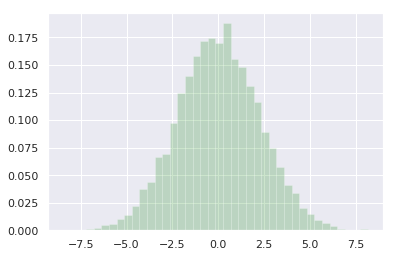

In [11]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    
generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Get synthetized data and corresponding MLE

In [12]:
train_w_mle, train_min_neg_loglikelihood = min_neg_loglikelihood()
val_w_mle, val_min_neg_loglikelihood = min_neg_loglikelihood(val=True)

# Training set
print('The maximum likelihood estimator on this train dataset is:')
print(train_w_mle)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_min_neg_loglikelihood)

print('\n')

# Validation set

print('The maximum likelihood estimator on this val dataset is:')
print(val_w_mle)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_min_neg_loglikelihood)

The maximum likelihood estimator on this train dataset is:
[1.975533]
The corresponding value for the negative log-likelihood for the training set is:
[2.2138348]


The maximum likelihood estimator on this val dataset is:
[2.0159473]
The corresponding value for the negative log-likelihood for the validation set is:
[2.2300212]


In [13]:
# TODO(nina): Add a comparison to a FA?

# Inspect results from standard VAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.9740]], device='cuda:0') 



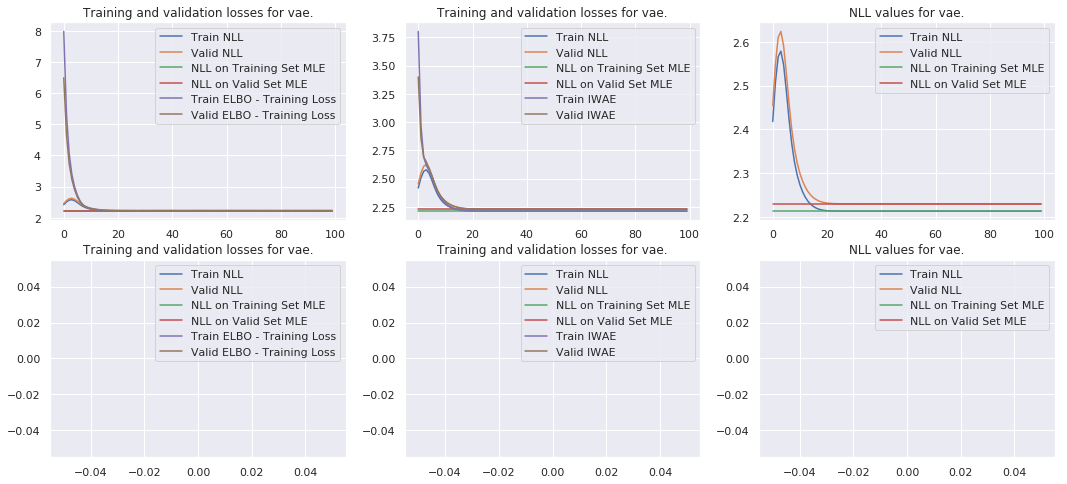

In [14]:
algo_name = 'vae'
from_epoch = 175
print_weights(algo_name=algo_name)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

ax = axes[0, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, trained_on_this=' - Training Loss')
ax = axes[1, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch, trained_on_this=' - Training Loss')

ax = axes[0, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name)
ax = axes[1, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

ax = axes[0, 2]
ax = plot_nlls(ax, algo_name=algo_name)
ax = axes[1, 2]
ax = plot_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.9740]], device='cuda:0') 

Expected biased w_elbo =  tensor([1.2047])


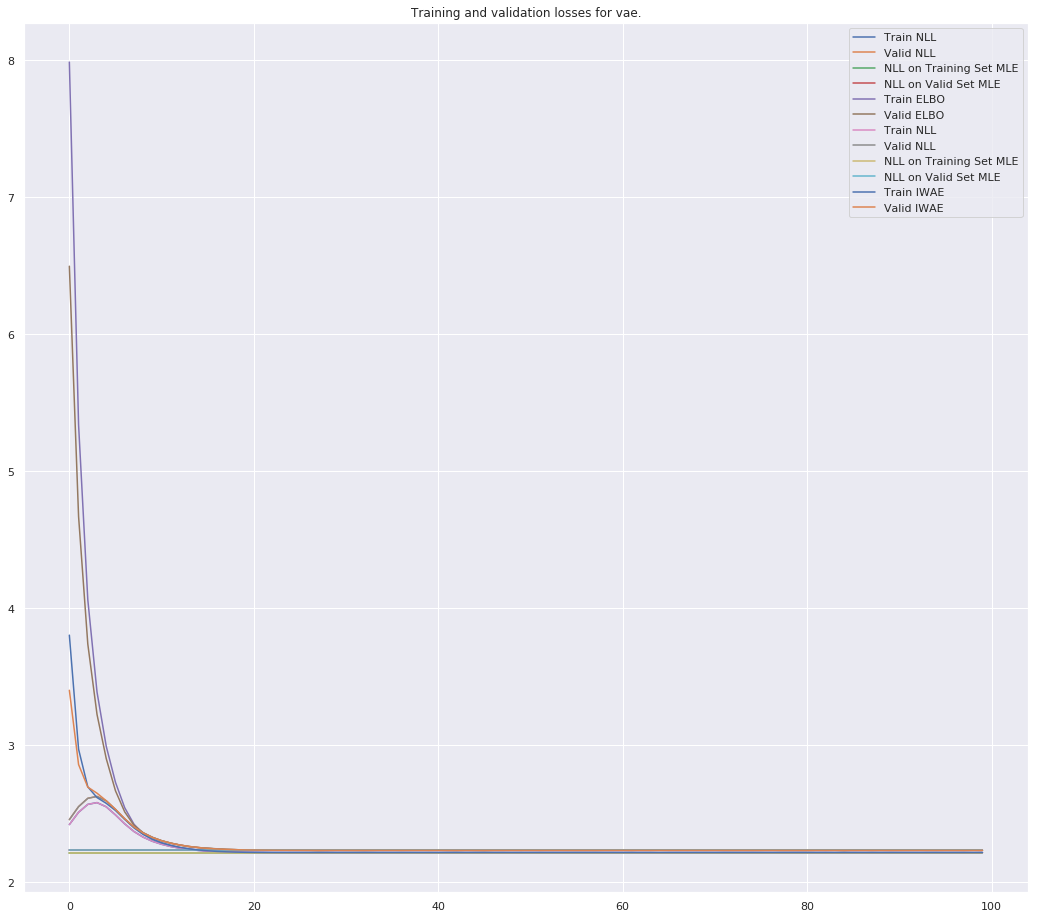

In [15]:
algo_name = 'vae'
print_weights(algo_name=algo_name)
from_epoch = 0

# Expected bias value of weight:
subdataset = torch.Tensor(dataset[:N_TRAIN,])
w_elbo_square = 0.5 * torch.mean(subdataset ** 2, dim=0) - 1 
w_elbo = torch.sqrt(w_elbo_square)
print('Expected biased w_elbo = ', w_elbo)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 16))

ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)



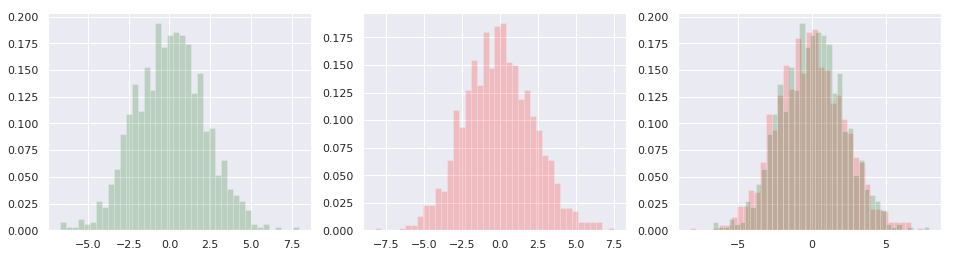

In [16]:
algo_name = 'vae'
decoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_x, color='red', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from IWAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.9740]], device='cuda:0') 



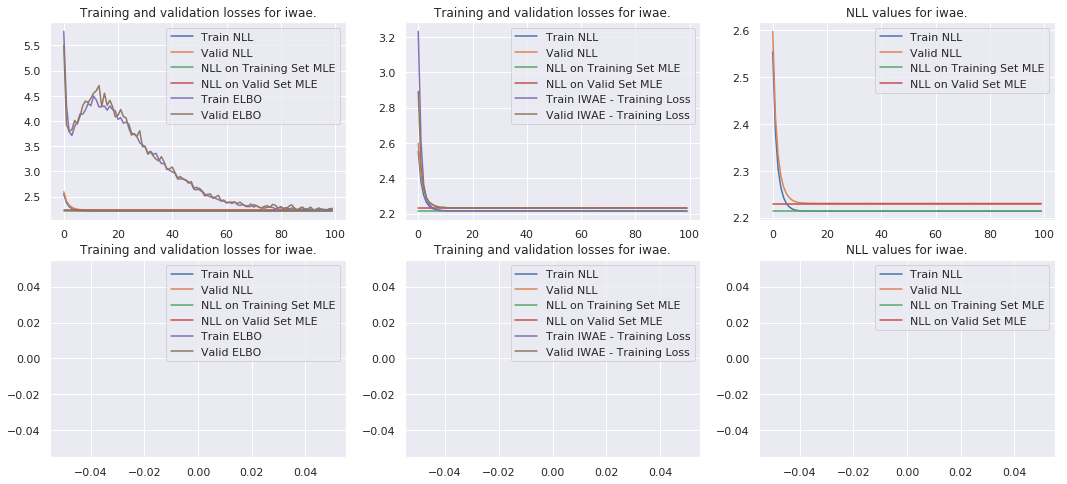

In [17]:
algo_name = 'iwae'
print_weights(algo_name=algo_name)
from_epoch = 175

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

ax = axes[0, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name)
ax = axes[1, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

ax = axes[0, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, trained_on_this=' - Training Loss')
ax = axes[1, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch, trained_on_this=' - Training Loss')

ax = axes[0, 2]
ax = plot_nlls(ax, algo_name=algo_name)
ax = axes[1, 2]
ax = plot_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.9740]], device='cuda:0') 



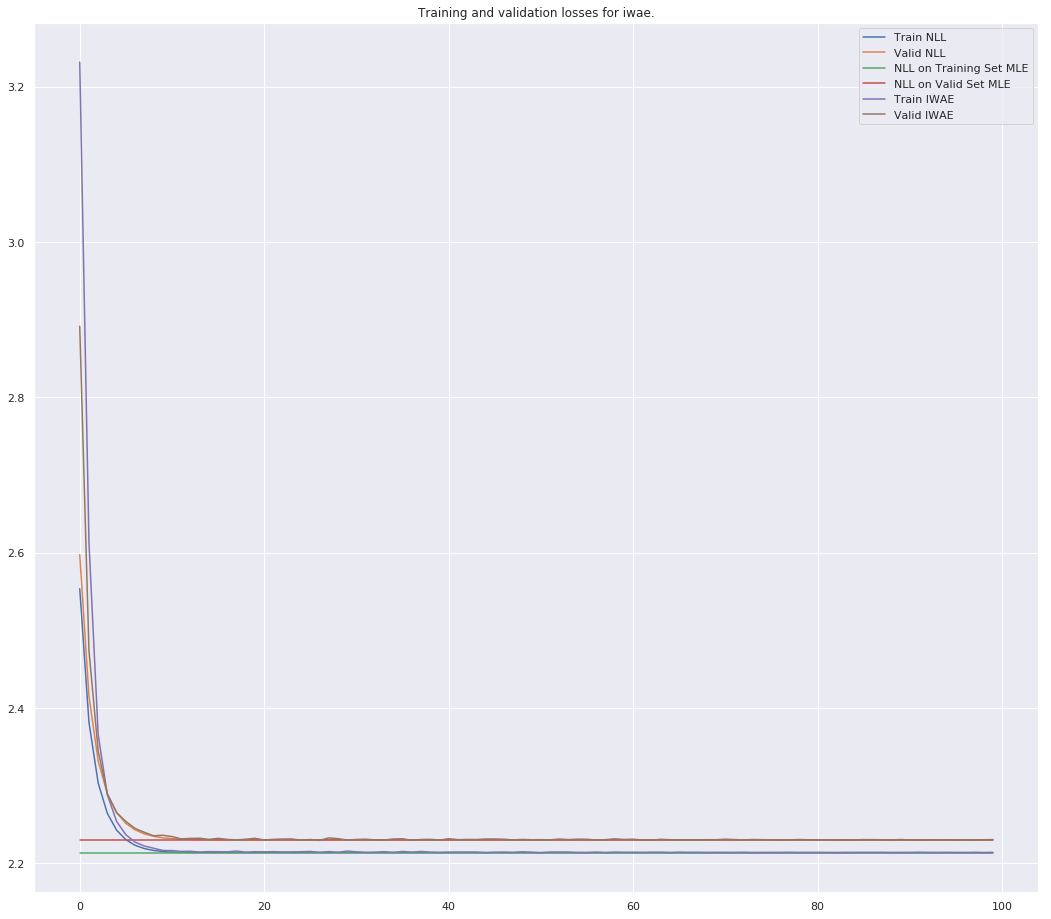

In [18]:
algo_name = 'iwae'
print_weights(algo_name=algo_name)
from_epoch = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 16))

ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

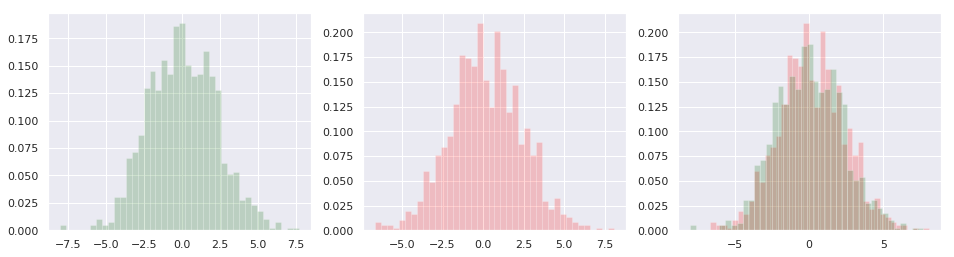

In [19]:
algo_name = 'iwae'
decoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_x, color='red', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from VEM

VEM trains on two losses, following the EM algorithm logic:
- The ELBO for the inference
- The IWAE for the learning

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.9727]], device='cuda:0') 



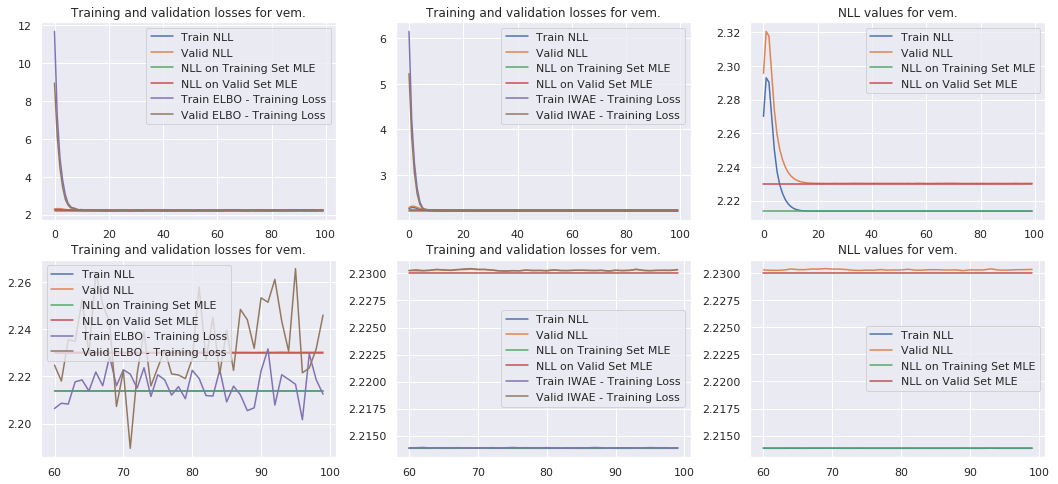

In [31]:
algo_name = 'vem'
print_weights(algo_name=algo_name)
from_epoch = 60

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

ax = axes[0, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, trained_on_this=' - Training Loss')
ax = axes[1, 0]
ax = plot_neg_elbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch, trained_on_this=' - Training Loss')

ax = axes[0, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, trained_on_this=' - Training Loss')
ax = axes[1, 1]
ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, from_epoch=from_epoch, trained_on_this=' - Training Loss')

ax = axes[0, 2]
ax = plot_nlls(ax, algo_name=algo_name)
ax = axes[1, 2]
ax = plot_nlls(ax, algo_name=algo_name, from_epoch=from_epoch)

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.9727]], device='cuda:0') 



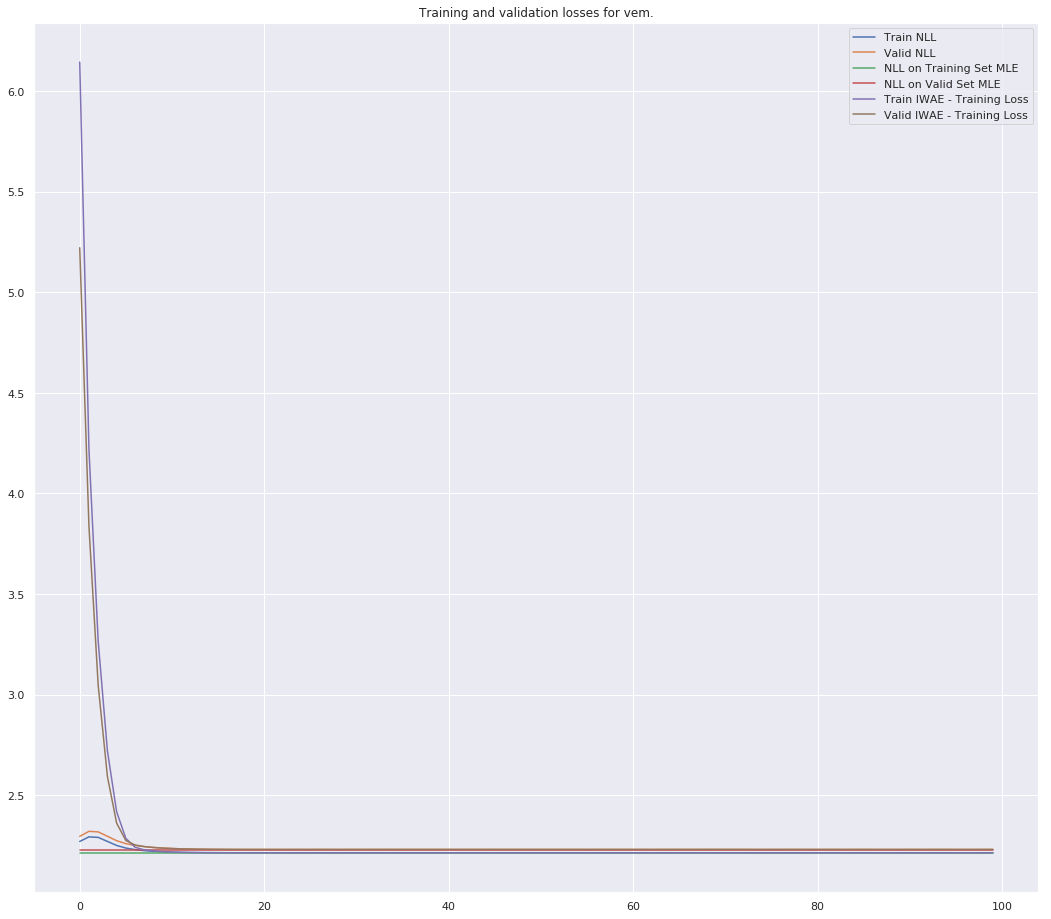

In [21]:
algo_name = 'vem'
print_weights(algo_name=algo_name)
from_epoch = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 16))

ax = plot_neg_iwelbo_and_nlls(ax, algo_name=algo_name, trained_on_this=' - Training Loss')

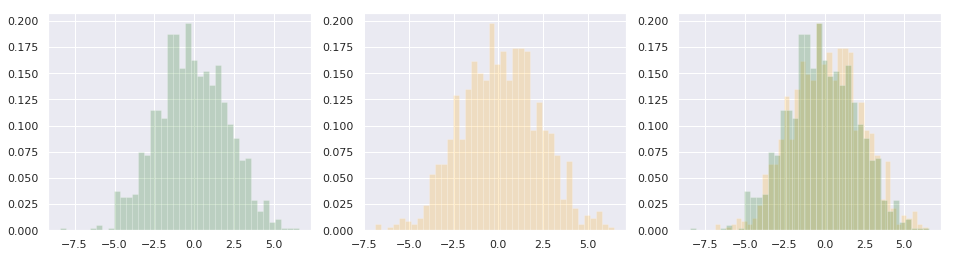

In [22]:
algo_name = 'vem'
decoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)


ax = axes[1]
toyvis.plot_data(generated_x, color='orange', ax=ax)


ax = axes[2]
toyvis.plot_data(generated_x, color='orange', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from VEGAN

In [51]:
algo_name = 'vegan'
print_weights(algo_name=algo_name)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax = axes[0, 0]
ax = plot_training_loss_and_nll(ax, algo_name=algo_name, loss_name='ELBO')

ax = axes[0, 1]
ax = plot_training_loss_and_nll(ax, algo_name=algo_name, loss_name='ELBO', from_epoch=300)

ax = axes[1, 0]
ax = plot_nll(ax, algo_name=algo_name)

ax = axes[1, 1]
ax = plot_nll(ax, algo_name=algo_name, from_epoch=300)


#print('Last losses:')
#print(train_losses_total[-5:]#)

IndexError: list index out of range

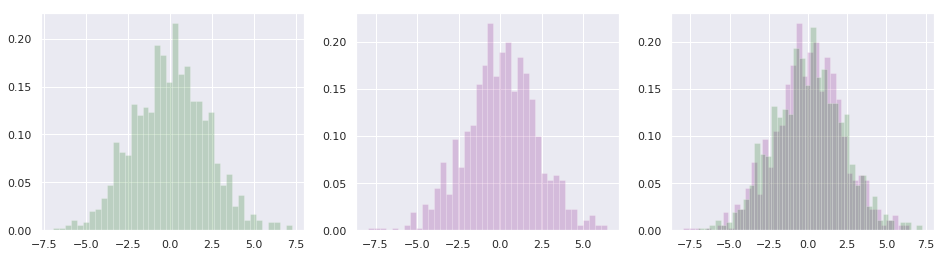

In [52]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)


ax = axes[1]
toyvis.plot_data(generated_x, color='purple', ax=ax)


ax = axes[2]
toyvis.plot_data(generated_x, color='purple', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Comparaison of NLL

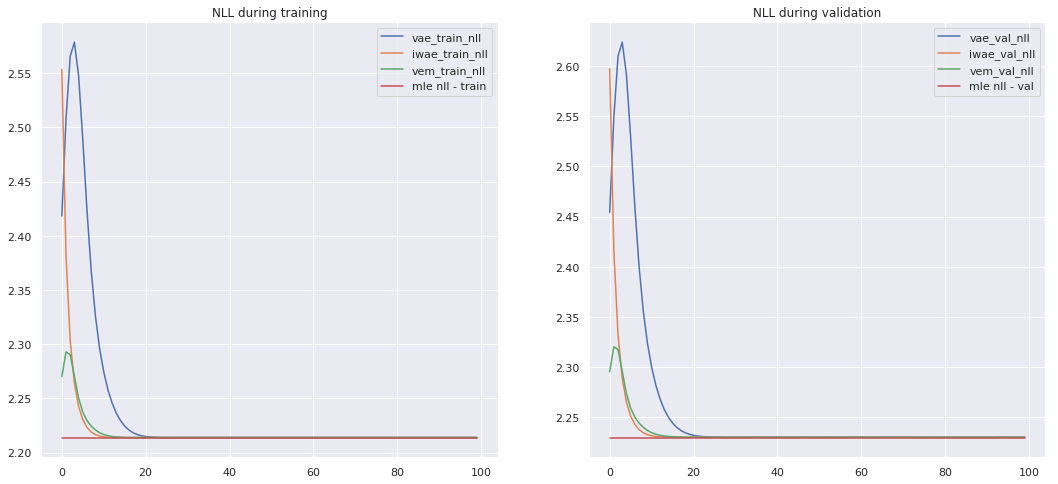

In [29]:
from_epoch = 0
train_w_mle, train_min_neg_loglikelihood = min_neg_loglikelihood()
val_w_mle, val_min_neg_loglikelihood = min_neg_loglikelihood(val=True)

train_losses_path = glob.glob(f'{OUTPUT}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vae/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

vae_train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
vae_val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]

train_losses_path = glob.glob(f'{OUTPUT}/train_iwae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_iwae/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

iwae_train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
iwae_val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]

train_losses_path = glob.glob(f'{OUTPUT}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vem/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

vem_train_nll = [loss['neg_loglikelihood'] for loss in train_losses_all_epochs]
vem_val_nll = [loss['neg_loglikelihood'] for loss in val_losses_all_epochs]

n_epochs = len(train_losses_all_epochs)
epochs = range(n_epochs)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

ax = axes[0]
ax.plot(epochs[from_epoch:], vae_train_nll[from_epoch:], label='vae_train_nll')
ax.plot(epochs[from_epoch:], iwae_train_nll[from_epoch:], label='iwae_train_nll')
ax.plot(epochs[from_epoch:], vem_train_nll[from_epoch:], label='vem_train_nll')
ax.plot(epochs[from_epoch:], np.repeat(train_min_neg_loglikelihood, n_epochs)[from_epoch:], label='mle nll - train')

ax.set_title('NLL during training')
ax.legend()

ax = axes[1]
ax.plot(epochs[from_epoch:], vae_val_nll[from_epoch:], label='vae_val_nll')
ax.plot(epochs[from_epoch:], iwae_val_nll[from_epoch:], label='iwae_val_nll')
ax.plot(epochs[from_epoch:], vem_val_nll[from_epoch:], label='vem_val_nll')
ax.plot(epochs[from_epoch:], np.repeat(val_min_neg_loglikelihood, n_epochs)[from_epoch:], label='mle nll - val')
ax.set_title('NLL during validation')
ax.legend()

# Comparison of times

# Print pipeline logs

In [37]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-11 20:36:40.619998.txt

2019-05-11 20:36:40,620 root         INFO     start
2019-05-11 20:36:40,634 luigi        INFO     logging configured by default settings
2019-05-11 20:36:40,659 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-11 20:36:40,661 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-11 20:36:40,661 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   TrainVEM__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   MakeDataSet__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   Trai